In [1]:
#data exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('data.csv')

In [3]:
# Check for missing values
missing_data = data.isnull().sum()

In [4]:
missing_data


PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
THROW_SIDE_KEY                  0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

In [5]:
# Visualize the distribution of some of the potentially affected features
features_to_plot = ['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED', 
                    'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X', 'PLATE_Z']

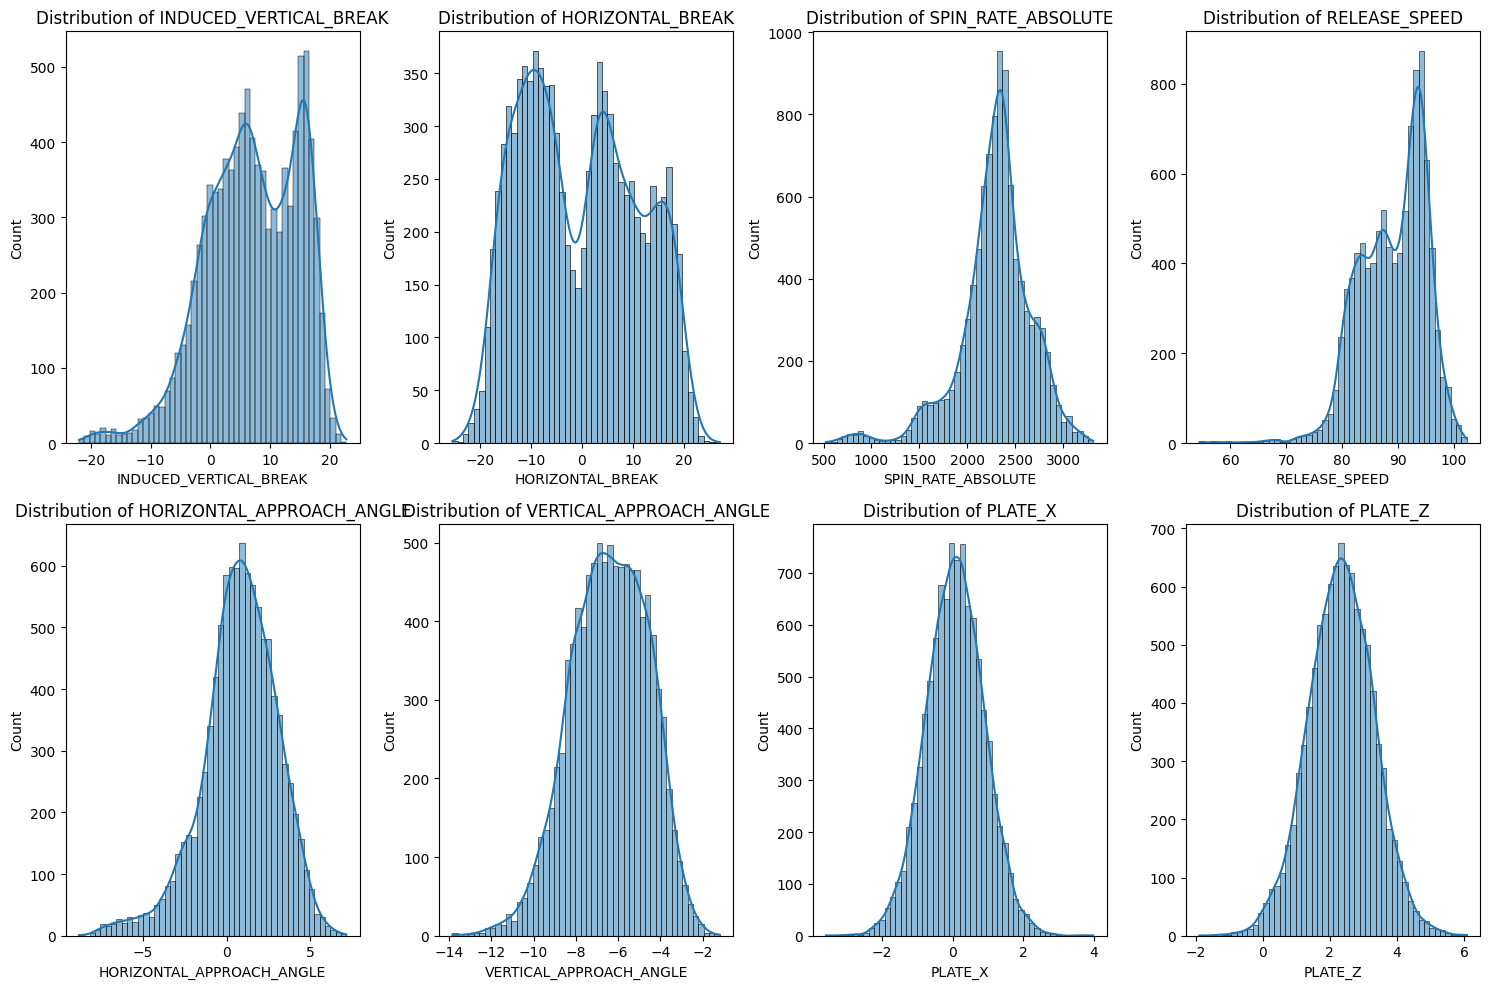

In [6]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()


In [7]:
# Feature Engineering

# Interaction between spin and speed
data['spin_speed_interaction'] = data['SPIN_RATE_ABSOLUTE'] * data['RELEASE_SPEED']

# Interaction between spin and vertical break
data['spin_vbreak_interaction'] = data['SPIN_RATE_ABSOLUTE'] * data['INDUCED_VERTICAL_BREAK']

# Interaction between spin and horizontal break
data['spin_hbreak_interaction'] = data['SPIN_RATE_ABSOLUTE'] * data['HORIZONTAL_BREAK']

# Interaction between speed and vertical break
data['speed_vbreak_interaction'] = data['RELEASE_SPEED'] * data['INDUCED_VERTICAL_BREAK']

# Interaction between speed and horizontal break
data['speed_hbreak_interaction'] = data['RELEASE_SPEED'] * data['HORIZONTAL_BREAK']

# Display the first few rows with the new features
data[['spin_speed_interaction', 'spin_vbreak_interaction', 'spin_hbreak_interaction', 
      'speed_vbreak_interaction', 'speed_hbreak_interaction']].head()


,spin_speed_interaction,spin_vbreak_interaction,spin_hbreak_interaction,speed_vbreak_interaction,speed_hbreak_interaction
0,242083.876498,34937.053457,-29695.126009,1465.344783,-1245.485628
1,228325.856782,32405.444483,-24895.069103,1431.523424,-1099.749598
2,207951.910770,12888.695039,10075.654647,500.348404,391.144154
3,210199.042552,11246.869486,9999.709018,431.578655,383.721085
4,217681.142997,10105.594342,3971.867060,367.842205,144.575399


In [8]:
from sklearn.ensemble import IsolationForest

# Features for the model
features = ['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED', 
            'spin_speed_interaction', 'spin_vbreak_interaction', 'spin_hbreak_interaction', 
            'speed_vbreak_interaction', 'speed_hbreak_interaction']

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model
iso_forest.fit(data[features])

# Predict anomaly scores (higher scores indicate higher probability of being an anomaly)
anomaly_scores = iso_forest.decision_function(data[features])

# Convert anomaly scores to probabilities (higher values indicate higher probability of being affected by dew point)
probabilities = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

probabilities[:10]


array([0.76874812, 0.81336192, 0.97748925, 0.95926073, 0.97870504,
       0.56969167, 0.55103453, 0.9271929 , 0.61933198, 0.76645349])

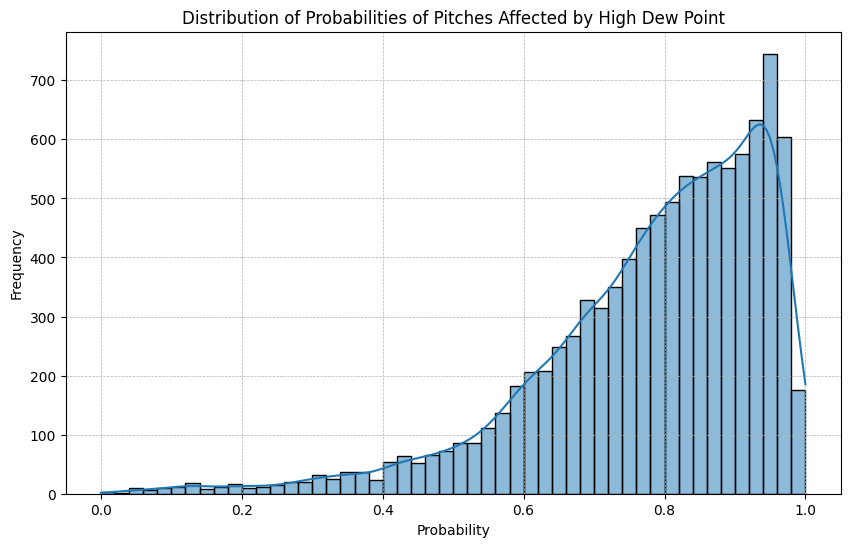

In [9]:
# Visualizing the distribution of probabilities
plt.figure(figsize=(10, 6))
sns.histplot(probabilities, bins=50, kde=True)
plt.title('Distribution of Probabilities of Pitches Affected by High Dew Point')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'PID': data['PID'],
    'DEWPOINT_AFFECTED': probabilities
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_HeysenPinto.csv', index=False)